In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import json,argparse
import numpy as np
import pandas as pd
# plot the data
import matplotlib.pyplot as plt
import natsort
import os

In [2]:


# Define the directory to search for log files
dir_ = "../final_analysis_cloudlab_io_twenty"

# Function to get GPU and main log files from the specified directory
def get_gpu_and_main_log_files(dir_path: str) -> tuple:
    import os
    gpu_files = []  # List to store GPU idle files
    gpu_util_files = []  # List to store GPU utilization files
    log_files = {}  # Dictionary to store main and worker log files

    # Walk through the directory and its subdirectories
    for root, dirs, files in os.walk(dir_path):
        log_files[root] = []  # Initialize the list for the current directory
        for file in files:
            # Check if the file is a GPU utilization file (excluding PNG files)
            if "gpu_util" in file and 'png' not in file:
                gpu_util_files.append(os.path.join(root, file))
            # Check if the file is a GPU idle file (excluding PNG files)
            if "gpu_idle" in file and 'png' not in file:
                gpu_files.append(os.path.join(root, file))
            # Check if the file is a main log file (excluding PNG files)
            if "main" in file and 'png' not in file:
                log_files[root].append(os.path.join(root, file))
            # Check if the file is a worker log file (excluding PNG files)
            if "worker" in file and 'png' not in file:
                log_files[root].append(os.path.join(root, file))

    # Return the lists of GPU idle files, main and worker log files, and GPU utilization files
    return gpu_files, log_files, gpu_util_files

# Get the GPU idle files, main and worker log files, and GPU utilization files from the specified directory
gpu_files, log_files, gpu_util_files = get_gpu_and_main_log_files(dir_)

# Filter out empty log file entries
log_files = {key: val for key, val in log_files.items() if val}

# Sort the log file keys naturally
log_files_keys = natsort.natsorted(log_files)

# Sort the GPU idle files naturally
gpu_files = natsort.natsorted(gpu_files)

# Sort the GPU utilization files naturally
gpu_util_files = natsort.natsorted(gpu_util_files)


In [3]:
df_dict_everything = {}

def get_batch_pin_memory_time_with_ts(log_file: str) -> pd.DataFrame:
    with open(log_file) as f:
        lines = f.readlines()
        batch_pin_memory_times = {}
        batch_pin_memory_times_ts = {}
        
        for line in lines:
            if "SBatchPinMemory" in line:
                parts = line.split(',')
                batch_id = int(parts[0].split('_')[1])
                pin_memory_time = float(parts[-1]) / (1000 * 1000 * 1000)
                batch_pin_memory_times[batch_id] = pin_memory_time
                batch_pin_memory_times_ts[batch_id] = float(parts[-2])
        
        data = {
            'batch_id': list(batch_pin_memory_times.keys()),
            'pin_memory_time': list(batch_pin_memory_times.values()),
            'pin_memory_time_ts': list(batch_pin_memory_times_ts.values())
        }
        
        df = pd.DataFrame(data)
        df.set_index('batch_id', inplace=True)
        df.sort_index(inplace=True)
        
        return df

def get_batch_idle_times_with_ts(log_file: str) -> pd.DataFrame:
    with open(log_file) as f:
        lines = f.readlines()
        batch_wait_times = {}
        batch_wait_times_ts = {}
        
        for line in lines:
            if "SBatchWait" in line:
                parts = line.split(',')
                batch_id = int(parts[0].split('_')[1])
                batch_wait_times[batch_id] = float(parts[2]) / (1000 * 1000 * 1000)
                batch_wait_times_ts[batch_id] = float(parts[1])
        
        data = {
            'batch_id': list(batch_wait_times.keys()),
            'wait_time': list(batch_wait_times.values()),
            'wait_time_ts': list(batch_wait_times_ts.values())
        }
        
        df = pd.DataFrame(data)
        df.set_index('batch_id', inplace=True)
        df.sort_index(inplace=True)
        
        return df

def get_batch_preprocessing_times_with_ts(log_file: str) -> pd.DataFrame:
    with open(log_file) as f:
        lines = f.readlines()
        batch_preprocessing_times = {}
        batch_preprocessing_times_ts = {}
        
        for line in lines:
            if "SBatchPreprocessed" in line:
                parts = line.split(',')
                batch_id = int(parts[0].split('_')[1])
                preprocessing_time = float(parts[-1]) / (1000 * 1000 * 1000)
                batch_preprocessing_times[batch_id] = preprocessing_time
                batch_preprocessing_times_ts[batch_id] = float(parts[-2])
        
        data = {
            'batch_id': list(batch_preprocessing_times.keys()),
            'preprocessing_time': list(batch_preprocessing_times.values()),
            'preprocessing_time_ts': list(batch_preprocessing_times_ts.values())
        }
        
        df = pd.DataFrame(data)
        df.set_index('batch_id', inplace=True)
        df.sort_index(inplace=True)
        
        return df

def get_batch_consumed_times_with_ts(log_file: str) -> pd.DataFrame:
    with open(log_file) as f:
        lines = f.readlines()
    batch_consumed_times = {}
    batch_consumed_times_ts = {}
    for line in lines:
        if "SBatchConsumed" in line:
            parts = line.split(',')
            batch_id = int(parts[0].split('_')[1])
            consumed_time = float(parts[-1]) / (1000 * 1000 * 1000)
            batch_consumed_times[batch_id] = consumed_time
            batch_consumed_times_ts[batch_id] = int(parts[-2])
    
    data = {
        'batch_id': list(batch_consumed_times.keys()),
        'consumed_time': list(batch_consumed_times.values()),
        'consumed_time_ts': list(batch_consumed_times_ts.values())
    }
    
    df = pd.DataFrame(data)
    df.set_index('batch_id', inplace=True)
    df.sort_index(inplace=True)
    
    return df

def get_gpu_util_time(gpu_util_file: str) -> pd.DataFrame:
    util_times = []
    batch_id = 1

    with open(gpu_util_file) as f:
        for line in f:
            if "ms" in line:
                util_time = float(line.split()[0]) / 1000
                util_times.append((batch_id, util_time))
                batch_id += 1

    df = pd.DataFrame(util_times, columns=['batch_id', 'util_time'])
    df.set_index('batch_id', inplace=True)
    df.sort_index(inplace=True)

    return df

def get_gpu_wait_time(gpu_file: str) -> pd.DataFrame:
    idle_times = []
    batch_id = 1
    
    with open(gpu_file) as f:
        for line in f:
            if "ms" in line:
                idle_time = float(line.split()[0]) / 1000
                idle_times.append((batch_id, idle_time))
                batch_id += 1
    
    df = pd.DataFrame(idle_times, columns=['batch_id', 'idle_time'])
    df.set_index('batch_id', inplace=True)
    df.sort_index(inplace=True)
    
    return df

def get_everything(log_files, gpu_file, gpu_util_file):
    # get e2e time
    df_main = None
    for file in log_files:
        if "main" in file:
            # get the batch wait time by ID
            df_batch_wait_times = get_batch_idle_times_with_ts(file)
            # concat with df_main using batch_id
            if df_main is None:
                df_main = df_batch_wait_times
            else:
                df_main = df_main.combine_first(df_batch_wait_times)

            df_batch_consumed_times = get_batch_consumed_times_with_ts(file)
            # concat with df_main using batch_id
            if df_main is None:
                df_main = df_batch_consumed_times
            else:
                df_main = df_main.combine_first(df_batch_consumed_times)
            
            df_batch_pin_memory_times = get_batch_pin_memory_time_with_ts(file)
            # concat with df_main using batch_id
            if df_main is None:
                df_main = df_batch_pin_memory_times
            else:
                df_main = df_main.combine_first(df_batch_pin_memory_times)
            
        if "worker" in file:
            # get batch preprocessing time by ID
            df_batch_preprocessing_times = get_batch_preprocessing_times_with_ts(file)
            # concat with df_main using batch_id
            if df_main is None:
                df_main = df_batch_preprocessing_times
            else:
                df_main = df_main.combine_first(df_batch_preprocessing_times)
    # in df_main, calculate wait_time_ts - (preprocessing_time_ts + preprocessing_time) for each batch and store in a new column
    df_main['wait_time_preprocessing_time_ts_diff'] = df_main['wait_time_ts']/(1000 * 1000 * 1000) - (df_main['preprocessing_time_ts']/(1000 * 1000 * 1000) + df_main['preprocessing_time'])
    df_main['wait_time_preprocessing_time_ts_diff'] = df_main['wait_time_preprocessing_time_ts_diff']
    # in df_main, calculate (consumed_time_ts - (preprocessing_time_ts + preprocessing_time) prefor each batch and store in a new column
    df_main['consumed_time_preprocessing_time_ts_diff'] = df_main['consumed_time_ts']/(1000 * 1000 * 1000) - (df_main['preprocessing_time_ts']/(1000 * 1000 * 1000) + df_main['preprocessing_time'])
    df_main['consumed_time_preprocessing_time_ts_diff'] = df_main['consumed_time_preprocessing_time_ts_diff']
    # get the idle times
    df_gpu = get_gpu_wait_time(gpu_file)
    df_gpu_util = get_gpu_util_time(gpu_util_file)
    # concat with df_main using batch_id
    # df_main = pd.concat([df_main,df_gpu],axis=1)
    df_main = df_main.combine_first(df_gpu)
    df_main = df_main.combine_first(df_gpu_util)
    return df_main

for key, gpu_file, gpu_util_file in zip(log_files_keys, gpu_files, gpu_util_files):
    log_files_list = log_files[key]
    # keep only the text after the last '/'
    key = key.split('/')[-1]
    print(key)
    df_dict_everything[key] = get_everything(log_files_list, gpu_file, gpu_util_file)


b128_gpu2_w4
b128_gpu2_w8
b128_gpu2_w12
b128_gpu2_w16
b128_gpu2_w20
b128_gpu2_w24
b128_gpu2_w28
b128_gpu3_w4
b128_gpu3_w8
b128_gpu3_w12
b128_gpu3_w16
b128_gpu3_w20
b128_gpu3_w24
b128_gpu3_w28
b128_gpu4_w4
b128_gpu4_w8
b128_gpu4_w12
b128_gpu4_w16
b128_gpu4_w20
b128_gpu4_w24
b128_gpu4_w28
b256_gpu2_w4
b256_gpu2_w8
b256_gpu2_w12
b256_gpu2_w16
b256_gpu2_w20
b256_gpu2_w24
b256_gpu2_w28
b256_gpu3_w4
b256_gpu3_w8
b256_gpu3_w12
b256_gpu3_w16
b256_gpu3_w20
b256_gpu3_w24
b256_gpu3_w28
b256_gpu4_w4
b256_gpu4_w8
b256_gpu4_w12
b256_gpu4_w16
b256_gpu4_w20
b256_gpu4_w24
b256_gpu4_w28
b512_gpu2_w4
b512_gpu2_w8
b512_gpu2_w12
b512_gpu2_w16
b512_gpu2_w20
b512_gpu2_w24
b512_gpu2_w28
b512_gpu3_w4
b512_gpu3_w8
b512_gpu3_w12
b512_gpu3_w16
b512_gpu3_w20
b512_gpu3_w24
b512_gpu3_w28
b512_gpu4_w4
b512_gpu4_w8
b512_gpu4_w12
b512_gpu4_w16
b512_gpu4_w20
b512_gpu4_w24
b512_gpu4_w28
b1024_gpu2_w4
b1024_gpu2_w8
b1024_gpu2_w12
b1024_gpu2_w16
b1024_gpu2_w20
b1024_gpu2_w24
b1024_gpu2_w28
b1024_gpu3_w4
b1024_gpu3_w8
b1024

In [4]:
def get_worker_log_files(dir_path: str) -> tuple:
    import os
    log_files = {}
    for root, dirs, files in os.walk(dir_path):
        log_files[root] = []
        for file in files:
            if "worker" in file and 'png' not in file:
                # log_files.append(os.path.join(root, file))
                log_files[root].append(os.path.join(root, file))
    return log_files


dir_ = "../final_analysis_cloudlab_io_twenty"

log_files = get_worker_log_files(dir_)
print(log_files)
# For each key, process the log files
df_worker = {}
for key in log_files:
    log_files_list = log_files[key]
    for log_file in log_files_list:
        if "worker" in log_file:
            df_worker[log_file] = get_batch_preprocessing_times_with_ts(log_file)

{'../final_analysis_cloudlab_io_twenty': [], '../final_analysis_cloudlab_io_twenty/b512_gpu4_w12': ['../final_analysis_cloudlab_io_twenty/b512_gpu4_w12/lotustrace_log_worker_pid_780853', '../final_analysis_cloudlab_io_twenty/b512_gpu4_w12/lotustrace_log_worker_pid_780628', '../final_analysis_cloudlab_io_twenty/b512_gpu4_w12/lotustrace_log_worker_pid_780564', '../final_analysis_cloudlab_io_twenty/b512_gpu4_w12/lotustrace_log_worker_pid_780596', '../final_analysis_cloudlab_io_twenty/b512_gpu4_w12/lotustrace_log_worker_pid_780789', '../final_analysis_cloudlab_io_twenty/b512_gpu4_w12/lotustrace_log_worker_pid_780725', '../final_analysis_cloudlab_io_twenty/b512_gpu4_w12/lotustrace_log_worker_pid_780885', '../final_analysis_cloudlab_io_twenty/b512_gpu4_w12/lotustrace_log_worker_pid_780693', '../final_analysis_cloudlab_io_twenty/b512_gpu4_w12/lotustrace_log_worker_pid_780917', '../final_analysis_cloudlab_io_twenty/b512_gpu4_w12/lotustrace_log_worker_pid_780821', '../final_analysis_cloudlab_io

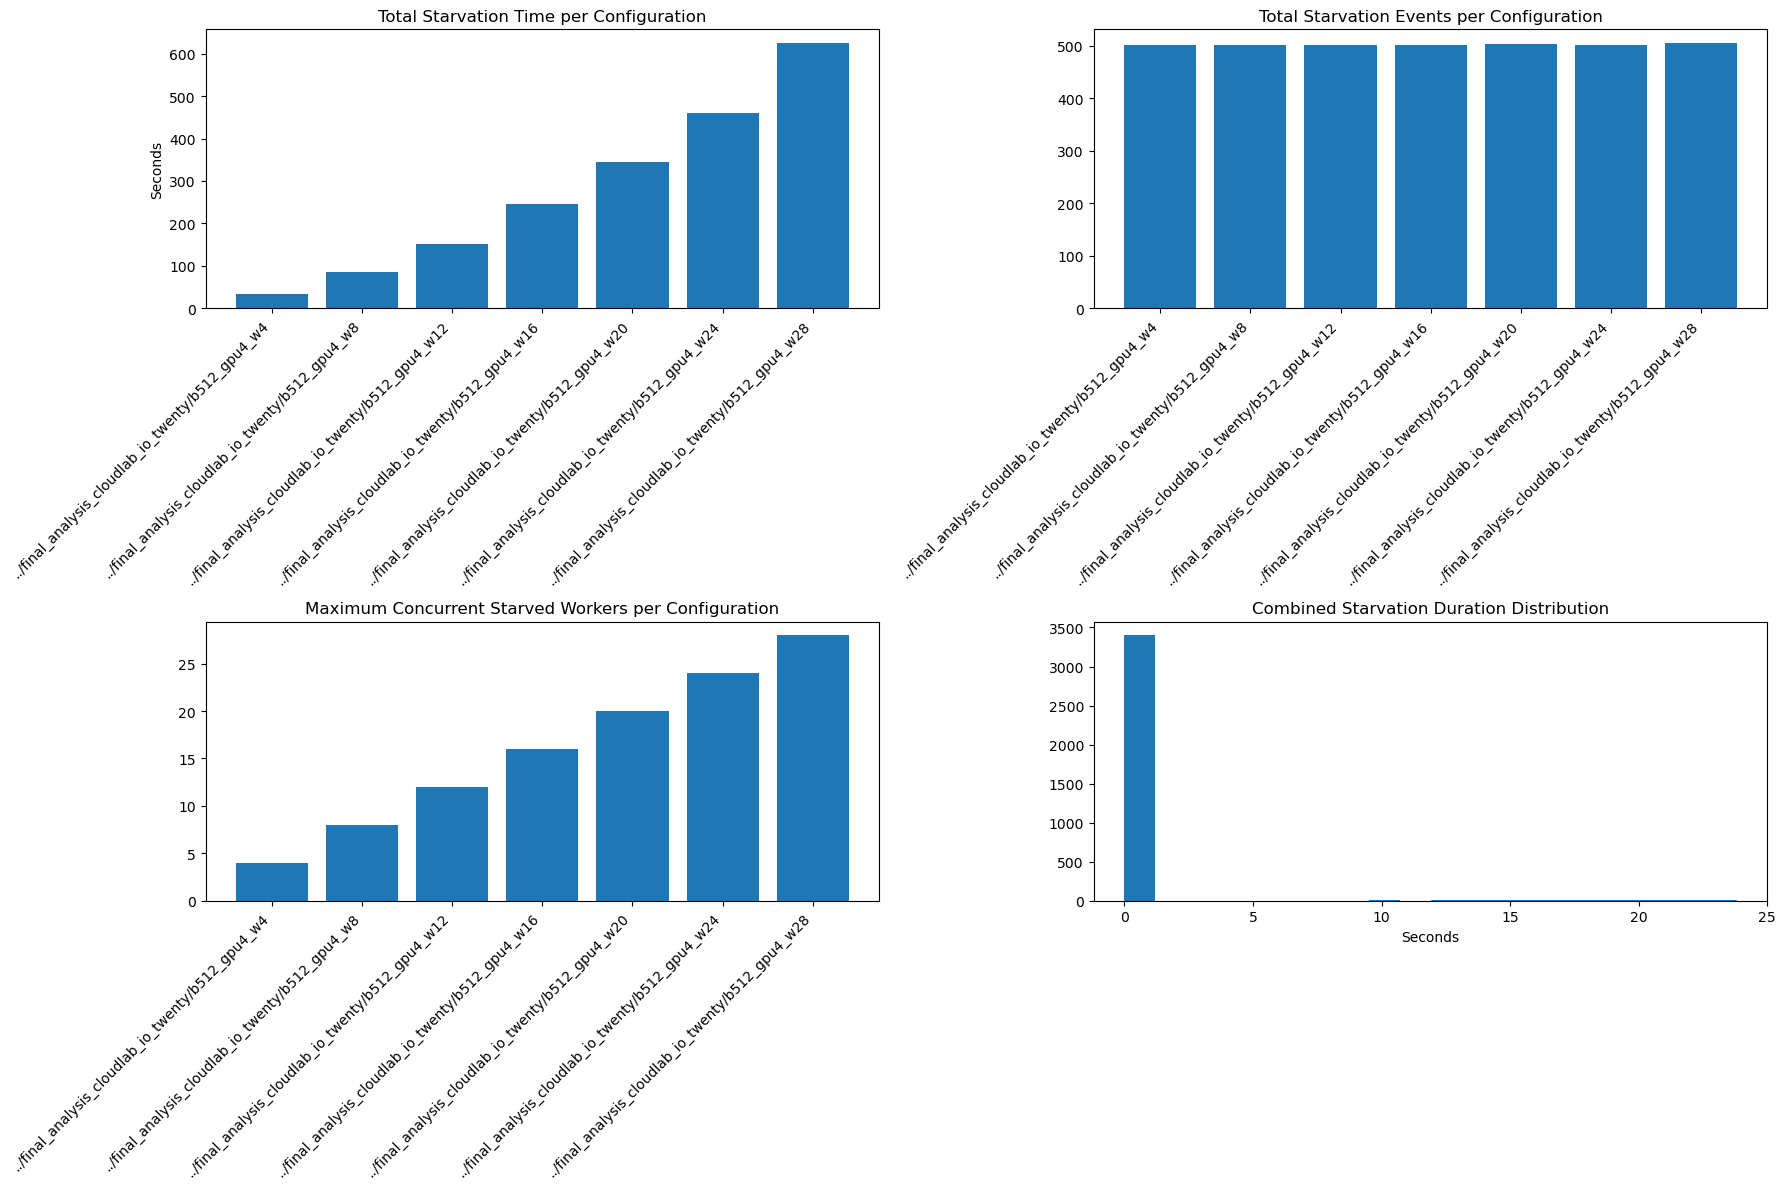

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import cycle
import os

def calculate_worker_starvation(df_worker):
    # Group workers by configuration
    config_groups = defaultdict(list)
    for worker_key in df_worker.keys():
        config_prefix = '/'.join(worker_key.split('/')[:-1])  # Get path before last segment
        if 'gpu4' not in config_prefix or 'b512' not in config_prefix:
            continue
        config_groups[config_prefix].append(worker_key)
    
    config_metrics = {}
    all_config_intervals = {}
    
    for config_prefix, worker_keys in config_groups.items():
        config_intervals = []
        config_starvation_data = {
            'total_starvation': 0,
            'max_starvation': 0,
            'starvation_count': 0,
            'workers': {}
        }
        
        for worker_key in worker_keys:
            worker_df = df_worker[worker_key]
            if worker_df.empty:
                continue
                
            # Sort by batch_id and convert timestamps
            worker_df = worker_df.sort_index()
            start_times = (worker_df['preprocessing_time_ts']/1e9) 
            end_times = worker_df['preprocessing_time_ts']/1e9 + worker_df['preprocessing_time']
            
            # Calculate starvation intervals for this worker
            worker_intervals = []
            total_starvation = 0
            max_starvation = 0
            
            for i in range(len(worker_df)-1):
                gap = start_times.iloc[i+1] - end_times.iloc[i]
                if gap > 0:
                    interval = (end_times.iloc[i], start_times.iloc[i+1])
                    worker_intervals.append(interval)
                    total_starvation += gap
                    max_starvation = max(max_starvation, gap)
                    config_intervals.append(interval)
            
            # Store per-worker metrics
            avg_starvation = total_starvation/len(worker_intervals) if worker_intervals else 0
            config_starvation_data['workers'][worker_key] = {
                'total_starvation': total_starvation,
                'avg_starvation': avg_starvation,
                'max_starvation': max_starvation,
                'starvation_count': len(worker_intervals)
            }
            
            # Update config-level metrics
            config_starvation_data['total_starvation'] += total_starvation
            config_starvation_data['max_starvation'] = max(
                config_starvation_data['max_starvation'], max_starvation)
            config_starvation_data['starvation_count'] += len(worker_intervals)
        
        # Calculate concurrent starvation for this configuration
        max_concurrent = 0
        if config_intervals:
            events = []
            for start, end in config_intervals:
                events.append((start, 'start'))
                events.append((end, 'end'))
            
            events.sort()
            current, max_concurrent = 0, 0
            
            for time, etype in events:
                current += 1 if etype == 'start' else -1
                max_concurrent = max(max_concurrent, current)
        
        config_starvation_data['max_concurrent'] = max_concurrent
        config_metrics[config_prefix] = config_starvation_data
        all_config_intervals[config_prefix] = config_intervals
    
    return config_metrics, all_config_intervals

def plot_starvation_metrics(config_metrics, all_config_intervals):
    config_names = natsort.natsorted(config_metrics.keys())
    
    # Extract metrics
    total_starvations = [config_metrics[config]['total_starvation'] for config in config_names]
    max_concurrents = [config_metrics[config]['max_concurrent'] for config in config_names]
    starvation_counts = [config_metrics[config]['starvation_count'] for config in config_names]
    
    # Create plots
    fig, ax = plt.subplots(2, 2, figsize=(18, 12))
    
    # Total Starvation per Configuration
    ax[0,0].bar(config_names, total_starvations)
    ax[0,0].set_title('Total Starvation Time per Configuration')
    ax[0,0].set_ylabel('Seconds')
    plt.sca(ax[0,0])
    plt.xticks(rotation=45, ha='right')
    
    # Starvation Events per Configuration
    ax[0,1].bar(config_names, starvation_counts)
    ax[0,1].set_title('Total Starvation Events per Configuration')
    plt.sca(ax[0,1])
    plt.xticks(rotation=45, ha='right')
    
    # Max Concurrent Starvation
    ax[1,0].bar(config_names, max_concurrents)
    ax[1,0].set_title('Maximum Concurrent Starved Workers per Configuration')
    plt.sca(ax[1,0])
    plt.xticks(rotation=45, ha='right')
    
    # Starvation Duration Distribution
    all_durations = []
    for config, intervals in all_config_intervals.items():
        all_durations.extend([end-start for start,end in intervals])
    ax[1,1].hist(all_durations, bins=20)
    ax[1,1].set_title('Combined Starvation Duration Distribution')
    ax[1,1].set_xlabel('Seconds')
    
    plt.tight_layout()
    plt.show()

# Usage
config_metrics, all_config_intervals = calculate_worker_starvation(df_worker)
plot_starvation_metrics(config_metrics, all_config_intervals)


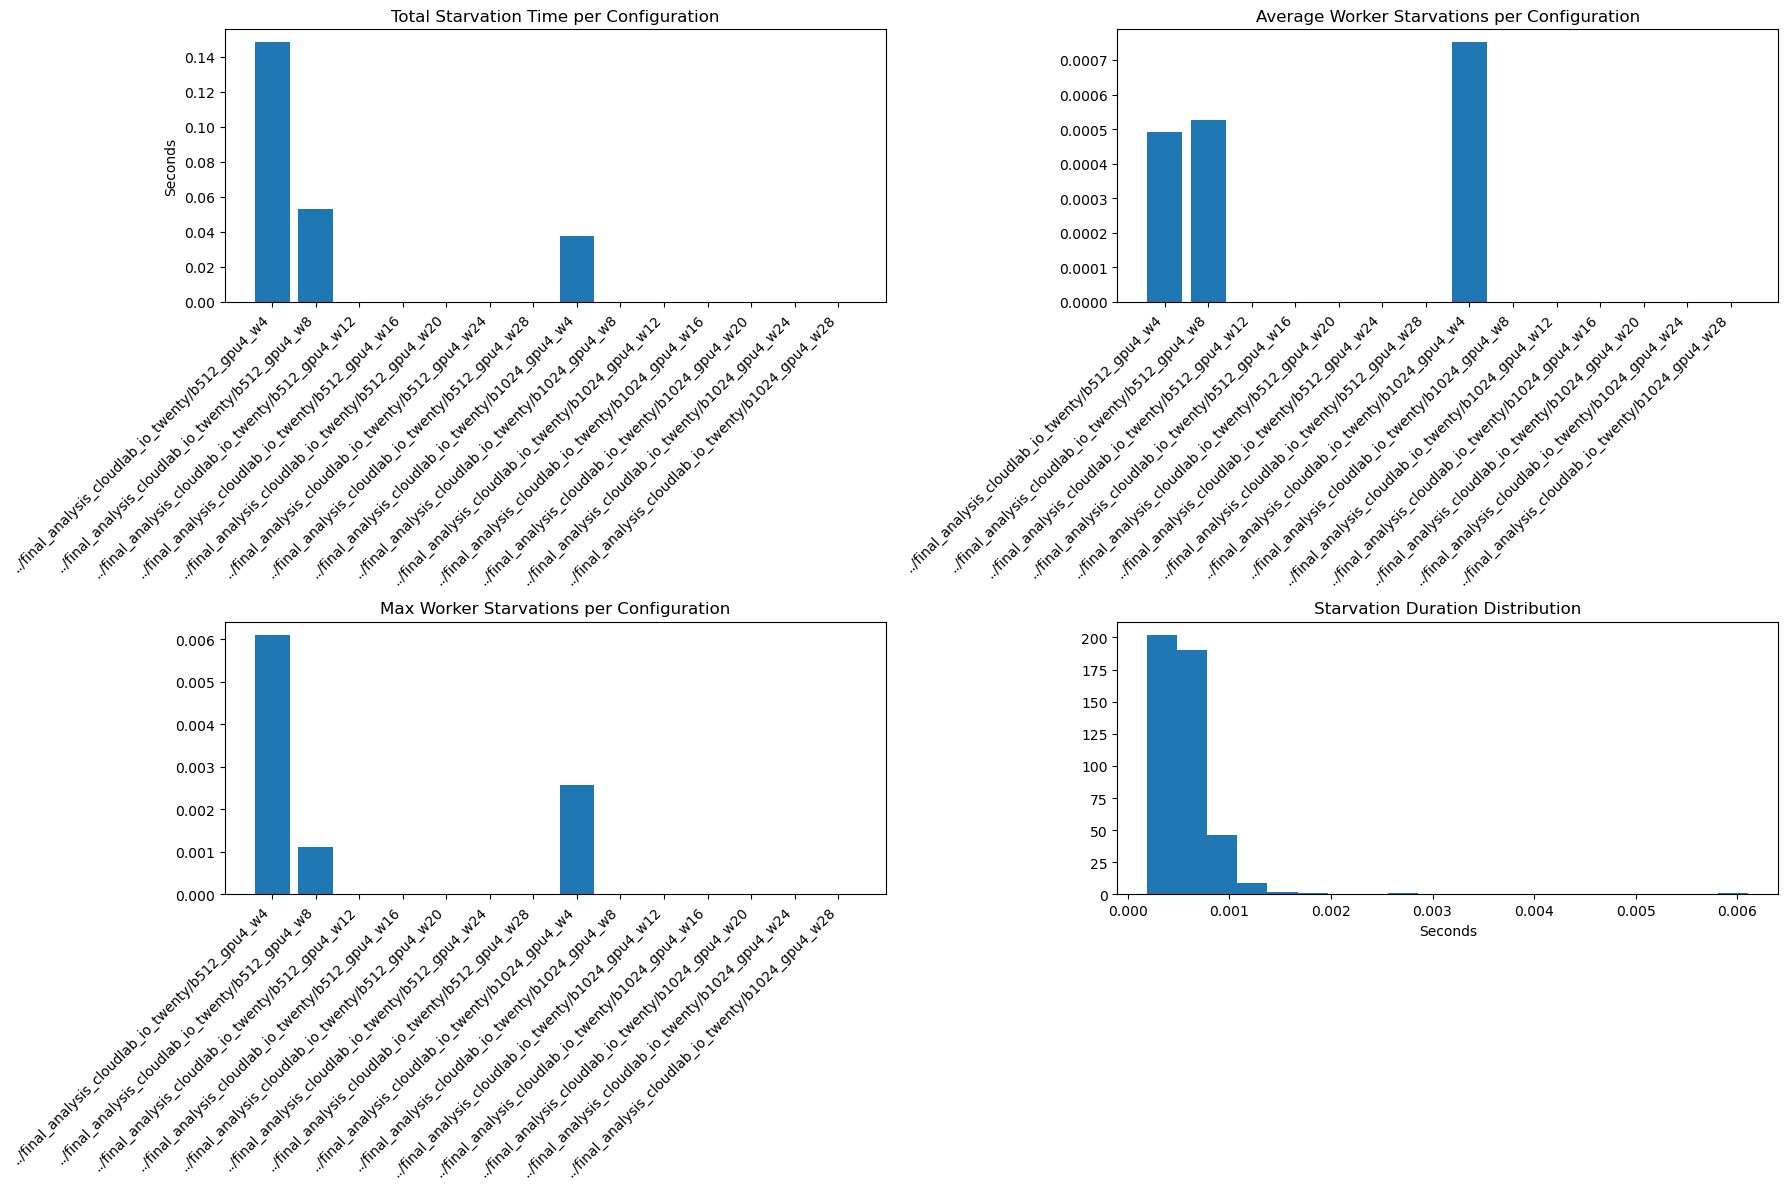

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import natsort

def calculate_worker_starvation(df_worker):
    # Group workers by configuration prefix
    config_groups = defaultdict(list)
    for worker_key in df_worker.keys():
        config_prefix = '/'.join(worker_key.split('/')[:-1])  # Get path before last segment
        if 'gpu4' not in config_prefix or ('b512' not in config_prefix and 'b1024' not in config_prefix):
            continue
        config_groups[config_prefix].append(worker_key)
    
    config_metrics = {}
    all_config_intervals = {}
    
    for config_prefix, worker_keys in config_groups.items():
        config_intervals = []
        config_starvation_data = {
            'total_starvation': 0,
            'max_starvation': 0,
            'starvation_count': 0,
            'workers': {}
        }
        
        for worker_key in worker_keys:
            worker_df = df_worker[worker_key]
            if worker_df.empty:
                continue
                
            # Sort by batch_id and convert timestamps
            worker_df = worker_df.sort_index()
            # skip the first 10 batches to avoid noise
            worker_df = worker_df.iloc[50:]
            start_times = (worker_df['preprocessing_time_ts'] / 1e9)
            end_times = worker_df['preprocessing_time_ts'] / 1e9 + worker_df['preprocessing_time']
            
            # Calculate starvation intervals for this worker
            worker_intervals = []
            total_starvation = 0
            max_starvation = 0
            
            for i in range(len(worker_df) - 1):
                gap = start_times.iloc[i + 1] - end_times.iloc[i]
                if gap > 0:
                    interval = (end_times.iloc[i], start_times.iloc[i + 1])
                    worker_intervals.append(interval)
                    total_starvation += gap
                    max_starvation = max(max_starvation, gap)
                    config_intervals.append(interval)
            
            # Store per-worker metrics
            avg_starvation = total_starvation / len(worker_intervals) if worker_intervals else 0
            config_starvation_data['workers'][worker_key] = {
                'total_starvation': total_starvation,
                'avg_starvation': avg_starvation,
                'max_starvation': max_starvation,
                'starvation_count': len(worker_intervals)
            }
            
            # Update config-level metrics
            config_starvation_data['total_starvation'] += total_starvation
            config_starvation_data['max_starvation'] = max(
                config_starvation_data['max_starvation'], max_starvation)
            config_starvation_data['starvation_count'] += len(worker_intervals)
        
        # Calculate concurrent starvation for this configuration
        max_concurrent = 0
        if config_intervals:
            events = []
            for start, end in config_intervals:
                events.append((start, 'start'))
                events.append((end, 'end'))
            
            events.sort()
            current, max_concurrent = 0, 0
            
            for time, etype in events:
                current += 1 if etype == 'start' else -1
                max_concurrent = max(max_concurrent, current)
        
        config_starvation_data['max_concurrent'] = max_concurrent
        config_metrics[config_prefix] = config_starvation_data
        all_config_intervals[config_prefix] = config_intervals
    
    return config_metrics, all_config_intervals

def plot_additional_metrics(config_metrics, all_config_intervals):
    # Natural sort configuration names
    config_names = natsort.natsorted(config_metrics.keys())
    
    # Extract metrics
    total_starvations = [config_metrics[config]['total_starvation'] for config in config_names]
    avg_worker_starvations = [
        sum(worker['avg_starvation'] for worker in config_metrics[config]['workers'].values()) /
        len(config_metrics[config]['workers'])
        for config in config_names
    ]
    max_worker_starvations = [
        max(worker['max_starvation'] for worker in config_metrics[config]['workers'].values())
        for config in config_names
    ]
    
    # Create plots
    fig, ax = plt.subplots(2, 2, figsize=(18, 12))
    
    # Total Starvation per Configuration
    ax[0,0].bar(config_names, total_starvations)
    ax[0,0].set_title('Total Starvation Time per Configuration')
    ax[0,0].set_ylabel('Seconds')
    plt.sca(ax[0,0])
    plt.xticks(rotation=45, ha='right')
    
    # Average Worker Starvations per Configuration
    ax[0,1].bar(config_names, avg_worker_starvations)
    ax[0,1].set_title('Average Worker Starvations per Configuration')
    plt.sca(ax[0,1])
    plt.xticks(rotation=45, ha='right')
    
    # Max Worker Starvations per Configuration
    ax[1,0].bar(config_names, max_worker_starvations)
    ax[1,0].set_title('Max Worker Starvations per Configuration')
    plt.sca(ax[1,0])
    plt.xticks(rotation=45, ha='right')
    
    # Starvation Duration Distribution (Histogram)
    all_durations = []
    for intervals in all_config_intervals.values():
        all_durations.extend([end-start for start,end in intervals])
    ax[1,1].hist(all_durations, bins=20)
    ax[1,1].set_title('Starvation Duration Distribution')
    ax[1,1].set_xlabel('Seconds')
    
    plt.tight_layout()
    plt.show()

# Usage Example:
config_metrics, all_config_intervals = calculate_worker_starvation(df_worker)
plot_additional_metrics(config_metrics, all_config_intervals)
